<a href="https://colab.research.google.com/github/adinsegall/A-Simple-Synth/blob/main/DL4AM_Coursework_Segall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL4AM Coursework: Combining Loop Candidacy Detection and Source Separation Models

Author: Adin Segall

This notebook contains the code, results, and analysis for the DL4AM coursework project focused on applying deep learning techniques to musical audio processing tasks. The goal is to implement and combine two distinct models:

1. A BiLSTM-based binary classifier to predict the "loopability" of short music segments (i.e. their suitability for seamless repetition). This model will learn on mel spectrogram input representations.  

2. A convolutional variational autoencoder (CVAE) to perform source separation on mixed audio signals, isolating individual instrumental elements. The CVAE will operate on magnitude spectrogram inputs and produce time-frequency masks to extract sources.

Both models will be trained and evaluated independently on the Free Music Archive (FMA) dataset, which provides source audio files, and optionally the Groove MIDI dataset for more granular rhythm pattern analysis. Key evaluation metrics will include accuracy and F1-score for the loop classifier, and signal-to-distortion ratio (SDR) and related source separation metrics for the CVAE.  

After developing the standalone models, different strategies for joint optimization and transfer learning will be explored to assess potential performance gains from shared feature extraction and end-to-end training.

The notebook is organized as follows:
1. Setup
   1.1 Imports
   1.2 Logging
   1.3 Device Configuration
2. Dataset Loading and Preprocessing
   2.1 FMA Dataset
   2.2 Groove MIDI Dataset
3. Model Implementations
4. Training Procedures
5. Evaluation and Results
6. Model Combination Strategies
7. Discussion and Interpretation
8. Conclusion and Future Directions

Code and analysis will be presented with the goal of academic rigor, suitable for conference submission in applied machine learning for audio. All key modeling choices and training details will be justified according to best practices established in the DL4AM module and relevant literature.

# 1. Setup

In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=5c4645f28014bef6f167ddfd2e660e178daaf8652265024c062301eb29213608
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
#@title 1.1 Imports

import os
import random
import time
import logging
import zipfile
from os import listdir
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchaudio
from torchaudio.transforms import MelSpectrogram

import torchvision
from torchvision import transforms

import librosa
import librosa.display
import pretty_midi

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
#@title 1.2 Logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
#@title 1.3 Device Configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#2. Datasets

In [5]:
#@title 2.0 Dataset Download and Setup

# Path to dataset storage inside Google Drive
drive_root = '/content/drive/MyDrive/DL4AM_datasets'

# Make sure the directory exists
os.makedirs(drive_root, exist_ok=True)

# Paths inside Google Drive
fma_small_zip = os.path.join(drive_root, 'fma_small.zip')
fma_small_folder = os.path.join(drive_root, 'fma_small')
fma_small_url = 'https://os.unil.cloud.switch.ch/fma/fma_small.zip'

fma_metadata_zip = os.path.join(drive_root, 'fma_metadata.zip')
fma_metadata_folder = os.path.join(drive_root, 'fma_metadata')
fma_metadata_url = 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'

egmd_zip = os.path.join(drive_root, 'e-gmd-v1.0.0-midi.zip')
egmd_folder = os.path.join(drive_root, 'e-gmd-v1.0.0-midi')
egmd_url = 'https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip'

# --- FMA Small ---
if not os.path.exists(fma_small_folder):
    print(f"Downloading FMA Small to {fma_small_zip}...")
    !wget -O "$fma_small_zip" "$fma_small_url"

    print(f"Extracting to {fma_small_folder}...")
    !unzip -q "$fma_small_zip" -d "$drive_root"
    os.remove(fma_small_zip)
else:
    print(f"FMA Small already exists at {fma_small_folder}")

# --- FMA Metadata ---
if not os.path.exists(fma_metadata_folder):
    print(f"Downloading FMA Metadata to {fma_metadata_zip}...")
    !wget -O "$fma_metadata_zip" "$fma_metadata_url"

    print(f"Extracting to {fma_metadata_folder}...")
    !unzip -q "$fma_metadata_zip" -d "$drive_root"
    os.remove(fma_metadata_zip)
else:
    print(f"FMA Metadata already exists at {fma_metadata_folder}")

# --- E-GMD MIDI ---
if not os.path.exists(egmd_folder):
    print(f"Downloading E-GMD MIDI to {egmd_zip}...")
    !wget -O "$egmd_zip" "$egmd_url"

    print(f"Extracting to {egmd_folder}...")
    with zipfile.ZipFile(egmd_zip, 'r') as zip_ref:
        zip_ref.extractall(drive_root)
    os.remove(egmd_zip)
else:
    print(f"E-GMD MIDI already exists at {egmd_folder}")

print("Dataset setup complete.")


FMA Small already exists at /content/drive/MyDrive/DL4AM_datasets/fma_small
FMA Metadata already exists at /content/drive/MyDrive/DL4AM_datasets/fma_metadata
E-GMD MIDI already exists at /content/drive/MyDrive/DL4AM_datasets/e-gmd-v1.0.0-midi
Dataset setup complete.


In [6]:
#@title 2.1 FMA Dataset

class FMADataset(Dataset):
    """Free Music Archive audio dataset (log-mel spectrograms + genre labels)."""
    def __init__(self, root_dir, metadata_file, transform=None,
                 n_mels=128, hop_length=512, sample_rate=22050, n_frames=860):
        """
        Args:
            root_dir (str): Path to FMA root directory (e.g., 'fma_small').
            metadata_file (str): Path to metadata CSV file (e.g., 'tracks.csv').
            transform (callable, optional): Optional transform to apply to each sample.
            n_mels (int): Number of mel bins.
            hop_length (int): Hop length for mel spectrogram.
            sample_rate (int): Target sample rate.
            n_frames (int): Target number of spectrogram frames (for trimming/padding).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.sample_rate = sample_rate
        self.n_frames = n_frames

        # Load metadata and filter valid tracks
        logger.info(f"Loading metadata from {metadata_file}")
        self.tracks = self._load_metadata(metadata_file)
        logger.info(f"Loaded metadata for {len(self.tracks)} tracks")

        # Find all MP3 files recursively in the root directory
        self.file_paths = self._find_mp3_files(root_dir)
        logger.info(f"Found {len(self.file_paths)} MP3 files in {root_dir}")

        # Match files to metadata and keep only valid tracks
        self._match_files_to_metadata()
        logger.info(f"Dataset contains {len(self.valid_indices)} valid tracks with metadata")

        # Create label encoder for genres
        self._create_label_encoder()

    def _load_metadata(self, metadata_file):
        """Load and parse the tracks metadata file"""
        metadata = pd.read_csv(metadata_file, index_col=0, header=[0, 1])

        # Keep only the tracks with a valid genre
        metadata = metadata[metadata['track', 'genre_top'].notna()]

        # Convert multi-level columns to single level for easier access
        metadata.columns = [f"{col[0]}_{col[1]}" for col in metadata.columns]

        return metadata

    def _find_mp3_files(self, root_dir):
        """Recursively find all MP3 files in the root directory"""
        file_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.mp3'):
                    file_paths.append(os.path.join(root, file))
        return file_paths

    def _match_files_to_metadata(self):
        """Match MP3 files to metadata entries"""
        self.valid_indices = []
        self.track_ids = []
        self.valid_file_paths = []

        for i, file_path in enumerate(self.file_paths):
            # Extract track ID from filename (remove .mp3 extension)
            filename = os.path.basename(file_path)
            try:
                track_id = int(filename.split('.')[0])

                # Check if track exists in metadata
                if track_id in self.tracks.index:
                    self.valid_indices.append(i)
                    self.track_ids.append(track_id)
                    self.valid_file_paths.append(file_path)
            except:
                # Skip files with invalid names
                continue

    def _create_label_encoder(self):
        """Create a label encoder for genre labels"""
        genres = [self.tracks.loc[track_id, 'track_genre_top'] for track_id in self.track_ids]
        self.encoder = LabelEncoder()
        self.encoder.fit(genres)
        self.num_classes = len(self.encoder.classes_)
        logger.info(f"Found {self.num_classes} unique genre classes")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Get file path and track ID
        file_path = self.valid_file_paths[idx]
        track_id = self.track_ids[idx]

        try:
            # Load audio file
            waveform, sr = torchaudio.load(file_path)

            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Resample if necessary
            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

            # Convert to numpy for librosa processing
            waveform_np = waveform.numpy().squeeze()

            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=waveform_np,
                sr=self.sample_rate,
                n_mels=self.n_mels,
                hop_length=self.hop_length
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Normalize to zero mean, unit variance
            log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-9)

            # Pad or trim to fixed frame length
            if log_mel_spec.shape[1] < self.n_frames:
                pad_width = self.n_frames - log_mel_spec.shape[1]
                log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            else:
                log_mel_spec = log_mel_spec[:, :self.n_frames]

            # Add channel dimension
            log_mel_spec = log_mel_spec[np.newaxis, :, :]

            # Get genre label
            genre = self.tracks.loc[track_id, 'track_genre_top']
            label = self.encoder.transform([genre])[0]

            sample = {
                'spectrogram': torch.tensor(log_mel_spec, dtype=torch.float32),
                'class_label': label,
                'track_id': track_id
            }

            if self.transform:
                sample = self.transform(sample)

            return sample

        except Exception as e:
            logger.warning(f"Error processing {file_path}: {e}")
            # Return a dummy sample as fallback (you might want to handle this differently)
            return {
                'spectrogram': torch.zeros((1, self.n_mels, self.n_frames), dtype=torch.float32),
                'class_label': 0,
                'track_id': track_id
            }

    def get_train_val_indices(self, val_size=0.2, random_state=42):
        """Create random train/validation split indices"""
        indices = list(range(len(self.valid_indices)))
        n_val = int(len(indices) * val_size)

        # Shuffle indices
        np.random.seed(random_state)
        np.random.shuffle(indices)

        # Split indices
        train_indices = indices[n_val:]
        val_indices = indices[:n_val]

        return train_indices, val_indices

In [7]:
#@title 2.2 Groove MIDI Dataset

class GrooveMIDIDataset(Dataset):
    def __init__(self, root_dir, max_files=50, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.max_files = max_files

        # Get list of MIDI files
        self.midi_files = [os.path.join(root_dir, 'midi', f) for f in os.listdir(os.path.join(root_dir, 'midi'))]

        # Randomly select a subset of MIDI files
        if len(self.midi_files) > max_files:
            self.midi_files = random.sample(self.midi_files, max_files)

        logger.info(f'Loaded {len(self.midi_files)} MIDI files from {root_dir}')

    def __len__(self):
        return len(self.midi_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        midi_path = self.midi_files[idx]

        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(midi_path)

            # Extract features
            onsets = []
            velocities = []
            durations = []
            microtimings = []

            for instrument in midi_data.instruments:
                if not instrument.is_drum:
                    for note in instrument.notes:
                        onsets.append(midi_data.time_to_tick(note.start) / midi_data.resolution)
                        velocities.append(note.velocity)
                        durations.append(midi_data.time_to_tick(note.end - note.start) / midi_data.resolution)
                        microtimings.append((note.start - midi_data.tick_to_time(midi_data.time_to_tick(note.start))) * midi_data.resolution)

            # Create feature matrix
            n_frames = 128  # Adjust as needed
            onset_frame = np.zeros((n_frames,))
            velocity_frame = np.zeros((n_frames,))
            duration_frame = np.zeros((n_frames,))
            microtiming_frame = np.zeros((n_frames,))

            for onset, velocity, duration, microtiming in zip(onsets, velocities, durations, microtimings):
                onset_idx = int(onset * (n_frames - 1))
                onset_frame[onset_idx] = 1
                velocity_frame[onset_idx] = velocity
                duration_frame[onset_idx] = duration
                microtiming_frame[onset_idx] = microtiming

            # Stack features into a matrix
            feature_matrix = np.stack((onset_frame, velocity_frame, duration_frame, microtiming_frame))

            # Normalize feature matrix
            mean = feature_matrix.mean()
            std = feature_matrix.std()
            feature_matrix = (feature_matrix - mean) / std

            # Add channel dimension
            feature_matrix = feature_matrix[np.newaxis, :, :]

            # Create sample dictionary
            sample = {'feature_matrix': feature_matrix,
                      'midi_path': midi_path}

            if self.transform:
                sample = self.transform(sample)

            return sample

        except Exception as e:
            logger.warning(f'Failed to load {midi_path}. Error: {e}')
            return self.__getitem__(random.randint(0, self.__len__() - 1))

In [8]:
#@title 2.3 Dataset Instantiation and DataLoaders
# Define paths to your data and metadata
fma_small_dir = "/content/drive/MyDrive/DL4AM_datasets/fma_small"
fma_metadata_file = "/content/drive/MyDrive/DL4AM_datasets/fma_metadata/tracks.csv"

# Create dataset instance
logger.info("Creating FMA dataset instance...")
fma_dataset = FMADataset(
    root_dir=fma_small_dir,
    metadata_file=fma_metadata_file,
    transform=None,  # No transform needed since we handle tensor conversion in __getitem__
    n_mels=128,
    hop_length=512,
    sample_rate=22050,
    n_frames=860
)

# Create random train/validation split indices (80% train, 20% validation)
train_indices, val_indices = fma_dataset.get_train_val_indices(val_size=0.2, random_state=42)
logger.info(f"Train set: {len(train_indices)} samples, Validation set: {len(val_indices)} samples")

# Create data loaders for CVAE model
cvae_train_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=4,
    pin_memory=True
)

cvae_val_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(val_indices),
    num_workers=4,
    pin_memory=True
)

# Create data loaders for BiLSTM model (using the same dataset and split)
bilstm_train_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=4,
    pin_memory=True
)

bilstm_val_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(val_indices),
    num_workers=4,
    pin_memory=True
)

# Test the data loader
logger.info("Testing data loader...")
try:
    sample_batch = next(iter(cvae_train_loader))
    logger.info(f"Sample batch spectrogram shape: {sample_batch['spectrogram'].shape}")
    logger.info(f"Sample batch class labels: {sample_batch['class_label'][:5]}")  # Show first 5 labels
except Exception as e:
    logger.error(f"Error testing data loader: {e}")

#3 Models

In [54]:
#@title 3.1 CVAE Source Separator

#helper function
def compute_conv_output_shape(input_dim, n_frames, layers, kernel_sizes, strides, padding=1):
    h, w = input_dim, n_frames
    for kernel_size, stride in zip(kernel_sizes, strides):
        h = (h + 2*padding - kernel_size) // stride + 1
        w = (w + 2*padding - kernel_size) // stride + 1
    return h, w

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_frames=860, kernel_sizes=[3, 3, 3], strides=[2, 2, 2]):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_sizes[0], stride=strides[0], padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], stride=strides[1], padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], stride=strides[2], padding=1)
        h, w = compute_conv_output_shape(input_dim, n_frames, len(kernel_sizes), kernel_sizes, strides)
        self.flatten_size = 128 * h * w

        self.fc1 = nn.Linear(self.flatten_size, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_frames=860, kernel_sizes=[3, 3, 3], strides=[2, 2, 2]):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.n_frames = n_frames

        h, w = compute_conv_output_shape(output_dim, n_frames, len(kernel_sizes), kernel_sizes, strides)
        self.encoded_channels = 128
        self.encoded_height = h
        self.encoded_width = w
        self.flatten_size = self.encoded_channels * self.encoded_height * self.encoded_width

        self.fc2 = nn.Linear(hidden_dim, self.flatten_size)

        # Transposed convolutions for upsampling
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=kernel_sizes[2], stride=strides[2], padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=kernel_sizes[1], stride=strides[1], padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=kernel_sizes[0], stride=strides[0], padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.shape[0], self.encoded_channels, self.encoded_height, self.encoded_width)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        # Ensure the output has the exact same dimensions as the input
        x = F.interpolate(x, size=(128, self.n_frames), mode='bilinear', align_corners=False)

        reconstruction = torch.sigmoid(x)
        return reconstruction

# CVAE class with initialize_model method
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_frames=860, kernel_sizes=[3, 3, 3], strides=[2, 2, 2]):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel_sizes[0], stride=strides[0], padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], stride=strides[1], padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], stride=strides[2], padding=1),
            nn.ReLU(),
        )

        # Calculate flattened size using the updated compute_conv_output_shape function
        h, w = compute_conv_output_shape(input_dim, n_frames, len(kernel_sizes), kernel_sizes, strides)
        self.flatten_size = 128 * h * w

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flatten_size)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=kernel_sizes[2], stride=strides[2], padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_sizes[1], stride=strides[1], padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=kernel_sizes[0], stride=strides[0], padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.input_dim = input_dim
        self.n_frames = n_frames

    def initialize_model(self, device):
        self.apply(self._init_weights)
        self.to(device)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        x = self.fc_decoder(z)
        h, w = compute_conv_output_shape(self.input_dim, self.n_frames, len(self.encoder_conv), [layer.kernel_size[0] for layer in self.encoder_conv], [layer.stride[0] for layer in self.encoder_conv])
        x = x.view(x.size(0), 128, h, w)
        x = self.decoder_conv(x)
        # Ensure output dimensions match input
        if x.shape[2:] != (self.input_dim, self.n_frames):
            x = F.interpolate(x, size=(self.input_dim, self.n_frames), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var

In [10]:
#@title 3.2 BiLSTM Loop Candidacy Classifier

class BiLSTMLoopClassifier(nn.Module):
    """
    Bidirectional LSTM-based binary classifier for predicting loop candidacy.
    Takes mel spectrograms as input and outputs binary classification.
    """
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        """
        Args:
            input_dim (int): Number of input features (mel bins)
            hidden_dim (int): Hidden dimension of the LSTM
            num_layers (int): Number of LSTM layers
            dropout (float): Dropout probability (applied between LSTM layers and before final classification)
        """
        super(BiLSTMLoopClassifier, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Feature extraction from the LSTM output
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

        # Final classification layer
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass through the BiLSTM classifier.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 1, mel_bins, time_frames]

        Returns:
            torch.Tensor: Probability score for loop candidacy
        """
        batch_size = x.shape[0]

        # Reshape from [batch_size, 1, mel_bins, time_frames] to [batch_size, time_frames, mel_bins]
        # by removing channel dimension and transposing
        x = x.squeeze(1).transpose(1, 2)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, time_frames, hidden_dim*2]

        # Extract features from the last time step
        # Alternative: Use attention mechanism over all time steps
        last_hidden = lstm_out[:, -1, :]  # [batch_size, hidden_dim*2]

        # Feature processing
        x = F.relu(self.fc1(last_hidden))
        x = self.dropout(x)

        # Final classification
        logits = self.fc2(x)

        # Return sigmoid output for binary classification
        # return torch.sigmoid(logits).squeeze(-1)
        # Return raw logits for BCEWithLogitsLoss
        return logits.squeeze(-1)

class LSTMWithAttention(nn.Module):
    """
    Variation of the loop classifier that incorporates an attention mechanism
    over the LSTM outputs to better focus on parts of the sequence that
    are most relevant for loop candidacy prediction.
    """
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(LSTMWithAttention, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout

        # BiLSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Output layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Reshape from [batch_size, 1, mel_bins, time_frames] to [batch_size, time_frames, mel_bins]
        x = x.squeeze(1).transpose(1, 2)

        # Pass through BiLSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, time_frames, hidden_dim*2]

        # Calculate attention weights
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)

        # Apply attention weights to get context vector
        context = torch.sum(attention_weights * lstm_out, dim=1)

        # Process context vector
        x = F.relu(self.fc1(context))
        x = self.dropout(x)
        logits = self.fc2(x)

        # Return sigmoid output
        # return torch.sigmoid(logits).squeeze(-1)
        # Return raw logits for BCEWithLogitsLoss
        return logits.squeeze(-1)

class RhythmicFeatureExtractor(nn.Module):
    """
    Specialized convolutional module for extracting rhythmic features
    from spectrograms before passing to BiLSTM. This can help detect
    patterns that are important for loop candidacy.
    """
    def __init__(self, in_channels=1, out_channels=16):
        super(RhythmicFeatureExtractor, self).__init__()

        # Horizontal convolutions to capture time patterns
        self.time_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 7), padding=(0, 3)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2))
        )

        # Vertical convolutions to capture frequency patterns
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(7, 1), padding=(3, 0)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )

    def forward(self, x):
        # Apply time and frequency convolutions
        time_features = self.time_conv(x)  # Captures rhythm patterns
        freq_features = self.freq_conv(x)  # Captures tonal patterns

        # Concatenate features along the channel dimension
        return torch.cat([time_features, freq_features], dim=1)

class HybridLoopClassifier(nn.Module):
    """
    A hybrid model combining convolutional feature extraction with BiLSTM
    for loop candidacy classification. This architecture first extracts
    rhythmic and tonal patterns from the spectrogram using CNNs and then
    analyzes the temporal dependencies using a BiLSTM.
    """
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(HybridLoopClassifier, self).__init__()

        # Feature extractor
        self.feature_extractor = RhythmicFeatureExtractor(in_channels=1, out_channels=16)

        # Adapting dimensions for LSTM
        self.conv_adapt = nn.Conv2d(32, 1, kernel_size=1)

        # BiLSTM for sequence modeling (input dim is halved due to pooling)
        self.lstm = nn.LSTM(
            input_size=input_dim // 2,  # Reduced by frequency pooling
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Extract rhythmic features with CNN
        x = self.feature_extractor(x)  # [batch_size, 32, mel_bins/2, time_frames/2]

        # Adapt channels for LSTM
        x = self.conv_adapt(x)  # [batch_size, 1, mel_bins/2, time_frames/2]

        # Reshape for LSTM: [batch_size, time_frames/2, mel_bins/2]
        x = x.squeeze(1).transpose(1, 2)

        # Process with BiLSTM
        lstm_out, _ = self.lstm(x)

        # Global pooling across time
        x = lstm_out.transpose(1, 2)  # [batch_size, hidden_dim*2, time_frames/2]
        x = self.global_pool(x).squeeze(-1)  # [batch_size, hidden_dim*2]

        # Final classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)

        # return torch.sigmoid(logits).squeeze(-1)

        # Return raw logits for BCEWithLogitsLoss
        return logits.squeeze(-1)

#4 Training Procedures

In [44]:
#@title 4.1 CVAE Training Loop

def loss_function(recon_x, x, mu, log_var, beta=0.001):
    """
    Compute the CVAE loss function.

    Args:
        recon_x (torch.Tensor): The reconstructed spectrogram
        x (torch.Tensor): The original spectrogram
        mu (torch.Tensor): The mean of the latent Gaussian
        log_var (torch.Tensor): The log variance of the latent Gaussian
        beta (float): The weight for the KL divergence term

    Returns:
        tuple: (total_loss, reconstruction_loss, kl_divergence)
    """
    # MSE loss for reconstruction (can be replaced with BCE if needed)
    # reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')

    # BCE loss for reconstruction (alternative)
    reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')

    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss is reconstruction loss plus weighted KL divergence
    total_loss = reconstruction_loss + beta * kl_divergence

    return total_loss, reconstruction_loss, kl_divergence

def train_cvae(model, train_loader, val_loader=None, epochs=100, lr=1e-4,
              beta=0.001, device='cuda', checkpoint_dir='./checkpoints',
              checkpoint_interval=10, early_stopping_patience=10):

    """
    Train the CVAE model.

    Args:
        model (nn.Module): The CVAE model
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader, optional): DataLoader for validation data
        epochs (int): Number of training epochs
        lr (float): Learning rate
        beta (float): Weight for the KL divergence term
        device (str): Device to train on ('cuda' or 'cpu')
        checkpoint_dir (str): Directory to save model checkpoints
        checkpoint_interval (int): Save model every n epochs
        early_stopping_patience (int): Stop training if validation loss doesn't improve for n epochs

    Returns:
        nn.Module: The trained model
        dict: Training history
    """

    accumulation_steps = 8 #number of steps to accumulate gradients

    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Move model to device
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

    # Initialize training history
    history = {
        'train_loss': [],
        'train_recon_loss': [],
        'train_kl_loss': [],
        'val_loss': [],
        'val_recon_loss': [],
        'val_kl_loss': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = os.path.join(checkpoint_dir, 'cvae_best_model.pt')

    logger.info(f"Starting CVAE training for {epochs} epochs")

    for epoch in range(epochs):
        start_time = time.time()
        # Training phase
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0

        # Progress bar for training batches
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        # Training loop over batches
        for batch_idx, sample in enumerate(train_pbar):
            # Get spectrogram from sample
            data = sample['spectrogram'].to(device).float()

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(data)
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, beta)

            # Remove the gradient accumulation code
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Remove the redundant loss calculation and backward pass

            # Accumulate batch loss
            train_loss += loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_loss += kl_loss.item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': loss.item(),
                'recon_loss': recon_loss.item(),
                'kl_loss': kl_loss.item()
            })

        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_recon_loss = train_recon_loss / len(train_loader.dataset)
        avg_train_kl_loss = train_kl_loss / len(train_loader.dataset)

        # Store training loss in history
        history['train_loss'].append(avg_train_loss)
        history['train_recon_loss'].append(avg_train_recon_loss)
        history['train_kl_loss'].append(avg_train_kl_loss)

        # Log training metrics
        logger.info(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} "
                   f"(Recon: {avg_train_recon_loss:.4f}, KL: {avg_train_kl_loss:.4f})")

        logger.info(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_recon_loss = 0
            val_kl_loss = 0

            # No gradient calculation during validation
            with torch.no_grad():
                # Progress bar for validation batches
                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

                # Validation loop over batches
                for batch_idx, sample in enumerate(val_pbar):
                    # Get spectrogram from sample
                    data = sample['spectrogram'].to(device).float()

                    # Forward pass
                    recon_batch, mu, log_var = model(data)

                    # Calculate loss
                    loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, beta)

                    # Accumulate batch loss
                    val_loss += loss.item()
                    val_recon_loss += recon_loss.item()
                    val_kl_loss += kl_loss.item()

                    # Update progress bar
                    val_pbar.set_postfix({
                        'val_loss': loss.item(),
                        'val_recon_loss': recon_loss.item(),
                        'val_kl_loss': kl_loss.item()
                    })

            # Calculate average validation loss for the epoch
            avg_val_loss = val_loss / len(val_loader.dataset)
            avg_val_recon_loss = val_recon_loss / len(val_loader.dataset)
            avg_val_kl_loss = val_kl_loss / len(val_loader.dataset)

            # Store validation loss in history
            history['val_loss'].append(avg_val_loss)
            history['val_recon_loss'].append(avg_val_recon_loss)
            history['val_kl_loss'].append(avg_val_kl_loss)

            # Log validation metrics
            logger.info(f"Epoch {epoch+1}/{epochs} - Val Loss: {avg_val_loss:.4f} "
                       f"(Recon: {avg_val_recon_loss:.4f}, KL: {avg_val_kl_loss:.4f})")

            # Update learning rate based on validation loss
            scheduler.step(avg_val_loss)

            # Check for early stopping
            if avg_val_loss < best_val_loss:
                logger.info(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
                best_val_loss = avg_val_loss
                patience_counter = 0

                # Save the best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_val_loss,
                }, best_model_path)
                logger.info(f"Saved best model to {best_model_path}")
            else:
                patience_counter += 1
                logger.info(f"Validation loss did not improve. Patience: {patience_counter}/{early_stopping_patience}")

                if patience_counter >= early_stopping_patience:
                    logger.info(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save checkpoint periodically
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'cvae_epoch_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
            }, checkpoint_path)
            logger.info(f"Saved checkpoint to {checkpoint_path}")

    # Load the best model if validation was used
    if val_loader is not None and os.path.exists(best_model_path):
        logger.info(f"Loading best model from {best_model_path}")
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])

    logger.info("CVAE training completed")

    return model, history


def visualize_cvae_training(history):
    """
    Visualize the training history of the CVAE model.

    Args:
        history (dict): Training history containing loss metrics
    """
    plt.figure(figsize=(15, 5))

    # Plot total loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train')
    if 'val_loss' in history and len(history['val_loss']) > 0:
        plt.plot(history['val_loss'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history['train_recon_loss'], label='Train')
    if 'val_recon_loss' in history and len(history['val_recon_loss']) > 0:
        plt.plot(history['val_recon_loss'], label='Validation')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot KL divergence
    plt.subplot(1, 3, 3)
    plt.plot(history['train_kl_loss'], label='Train')
    if 'val_kl_loss' in history and len(history['val_kl_loss']) > 0:
        plt.plot(history['val_kl_loss'], label='Validation')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def generate_samples(model, num_samples=5, latent_dim=32, device='cuda'):
    """
    Generate samples from the trained CVAE model.

    Args:
        model (nn.Module): The trained CVAE model
        num_samples (int): Number of samples to generate
        latent_dim (int): Dimension of the latent space
        device (str): Device to use ('cuda' or 'cpu')

    Returns:
        torch.Tensor: Generated samples
    """
    model.eval()
    with torch.no_grad():
        # Sample from the latent space
        z = torch.randn(num_samples, latent_dim).to(device)

        # Decode the latent samples
        samples = model.decoder(z)

    return samples


def visualize_cvae_reconstructions(model, dataloader, num_examples=5, device='cuda'):
    """
    Visualize original spectrograms and their reconstructions.

    Args:
        model (nn.Module): The trained CVAE model
        dataloader (DataLoader): DataLoader containing the data
        num_examples (int): Number of examples to visualize
        device (str): Device to use ('cuda' or 'cpu')
    """
    # Set model to evaluation mode
    model.eval()

    # Get examples from dataloader
    examples = []
    for batch_idx, sample in enumerate(dataloader):
        if batch_idx >= num_examples:
            break
        examples.append(sample['spectrogram'])

    # Concatenate examples
    examples = torch.cat(examples[:num_examples])
    examples = examples.to(device)

    # Generate reconstructions
    with torch.no_grad():
        reconstructions, _, _ = model(examples)

    # Move tensors to CPU for visualization
    examples = examples.cpu()
    reconstructions = reconstructions.cpu()

    # Visualize originals and reconstructions
    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        # Original spectrogram
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(examples[i].squeeze(), cmap='viridis', origin='lower', aspect='auto')
        plt.title(f"Original {i+1}")
        plt.colorbar()

        # Reconstructed spectrogram
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(reconstructions[i].squeeze(), cmap='viridis', origin='lower', aspect='auto')
        plt.title(f"Reconstructed {i+1}")
        plt.colorbar()

    plt.tight_layout()
    plt.show()

In [12]:
#@title 4.2 BiLSTM Training Loop

def train_bilstm(model, train_loader, val_loader=None, epochs=100, lr=1e-3,
                device='cuda', checkpoint_dir='./checkpoints',
                checkpoint_interval=10, early_stopping_patience=10):
    """
    Train the BiLSTM model.

    Args:
        model (nn.Module): The BiLSTM model
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader, optional): DataLoader for validation data
        epochs (int): Number of training epochs
        lr (float): Learning rate
        device (str): Device to train on ('cuda' or 'cpu')
        checkpoint_dir (str): Directory to save model checkpoints
        checkpoint_interval (int): Save model every n epochs
        early_stopping_patience (int): Stop training if validation metric doesn't improve for n epochs

    Returns:
        nn.Module: The trained model
        dict: Training history
    """
    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Move model to device
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5, verbose=True)

    # Initialize training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    # Initialize early stopping
    best_val_f1 = 0.0
    patience_counter = 0
    best_model_path = os.path.join(checkpoint_dir, 'bilstm_best_model.pt')

    logger.info(f"Starting BiLSTM training for {epochs} epochs")

    for epoch in range(epochs):
        start_time = time.time()

        # Training loop
        model.train()
        train_loss = 0.0
        y_true_train = []
        y_pred_train = []

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for batch_idx, sample in enumerate(train_pbar):
            # Get spectrogram and labels from sample
            spec = sample['spectrogram'].to(device).float()
            labels = sample['class_label'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(spec)
            loss = F.binary_cross_entropy_with_logits(logits, labels.float())

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect true and predicted labels
            y_true_train.extend(labels.tolist())
            y_pred_train.extend((torch.sigmoid(logits) > 0.5).long().tolist())

            train_loss += loss.item() * len(labels)

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_precision = precision_score(y_true_train, y_pred_train)
        train_recall = recall_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train)

        # Store training metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        # Log training metrics
        logger.info(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Acc: {train_acc:.4f}, "
                    f"Precision: {train_precision:.4f}, "
                    f"Recall: {train_recall:.4f}, "
                    f"F1: {train_f1:.4f}")

        logger.info(f"Epoch {epoch+1} train completed in {time.time() - start_time:.2f} seconds")

        # Validation loop
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            y_true_val = []
            y_pred_val = []

            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

                for batch_idx, sample in enumerate(val_pbar):
                    spec = sample['spectrogram'].to(device).float()
                    labels = sample['class_label'].to(device)

                    logits = model(spec)
                    loss = F.binary_cross_entropy_with_logits(logits, labels.float())

                    y_true_val.extend(labels.tolist())
                    y_pred_val.extend((torch.sigmoid(logits) > 0.5).long().tolist())

                    val_loss += loss.item() * len(labels)

                    val_pbar.set_postfix({'val_loss': loss.item()})

            # Calculate validation metrics
            val_loss /= len(val_loader.dataset)
            val_acc = accuracy_score(y_true_val, y_pred_val)
            val_precision = precision_score(y_true_val, y_pred_val)
            val_recall = recall_score(y_true_val, y_pred_val)
            val_f1 = f1_score(y_true_val, y_pred_val)

            # Store validation metrics
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_precision'].append(val_precision)
            history['val_recall'].append(val_recall)
            history['val_f1'].append(val_f1)

            # Log validation metrics
            logger.info(f"Epoch {epoch+1}/{epochs} - "
                        f"Val Loss: {val_loss:.4f}, "
                        f"Acc: {val_acc:.4f}, "
                        f"Precision: {val_precision:.4f}, "
                        f"Recall: {val_recall:.4f}, "
                        f"F1: {val_f1:.4f}")

            # Update learning rate based on F1
            scheduler.step(val_f1)

            # Check early stopping
            if val_f1 > best_val_f1:
                logger.info(f"F1 improved from {best_val_f1:.4f} to {val_f1:.4f}")
                best_val_f1 = val_f1
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
                logger.info(f"Best model saved to {best_model_path}")
            else:
                patience_counter += 1
                logger.info(f"F1 did not improve. Patience: {patience_counter}/{early_stopping_patience}")

                if patience_counter == early_stopping_patience:
                    logger.info("Early stopping triggered")
                    break

        # Periodic checkpoints
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'bilstm_epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), checkpoint_path)
            logger.info(f"Checkpoint saved to {checkpoint_path}")

    # Load best model
    if val_loader is not None:
        model.load_state_dict(torch.load(best_model_path))
        logger.info(f"Best model loaded from {best_model_path}")

    logger.info("BiLSTM training completed")

    return model, history


def visualize_bilstm_training(history):
    """Visualization of BiLSTM training history."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    # Plot losses
    axes[0].plot(history['train_loss'], label='Train Loss')
    if 'val_loss' in history:
        axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    metric_names = ["Accuracy", "Precision", "Recall", "F1"]

    # Plot other metrics
    for i, name in enumerate(metric_names, start=1):
        train_key = f"train_{name.lower()}"
        val_key = f"val_{name.lower()}"

        axes[i].plot(history[train_key], label=f'Train {name}')
        if val_key in history:
            axes[i].plot(history[val_key], label=f'Validation {name}')
        axes[i].set_title(name)
        axes[i].set_xlabel("Epoch")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [13]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [16]:
# import torch
# # Define hyperparameter search space
# model = CVAE(
#     input_dim=128,  # Number of mel bands
#     hidden_dim=128,
#     latent_dim=cvae_p['latent_dim'],
#     n_frames=860    # Number of frames in your spectrograms
# )

# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# # print(model.state_dict())
# for name, param in model.named_parameters():
#     print(f"Parameter: {name}, Device: {param.device}")

NameError: name 'cvae_p' is not defined

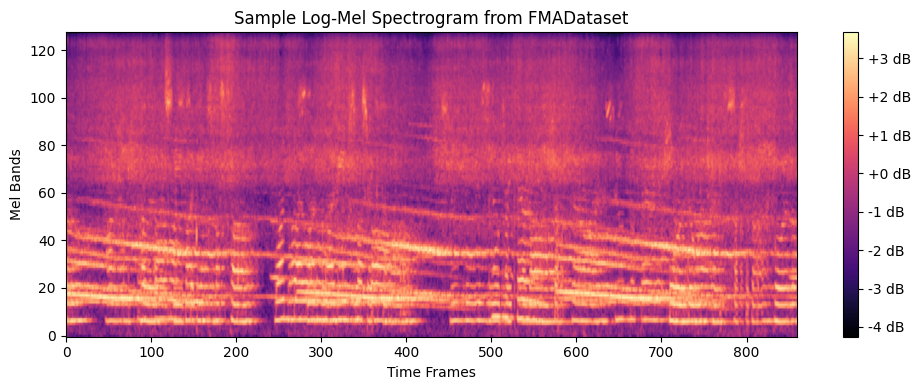

Saved dummy_spec.pt for upload.


In [20]:
# === Extract & Visualize a Sample from FMADataset ===

import torch
import matplotlib.pyplot as plt
import numpy as np

# === Load 1 sample from your dataset ===
sample = fma_dataset[0]  # Change index if you want a different sample
spectrogram = sample['spectrogram']  # Shape: [1, 128, 860] (or similar)

# === Convert to numpy for plotting ===
spec_np = spectrogram.squeeze().numpy()  # Shape: [128, 860]

# === Display the spectrogram ===
plt.figure(figsize=(10, 4))
plt.imshow(spec_np, origin='lower', aspect='auto', cmap='magma')
plt.title("Sample Log-Mel Spectrogram from FMADataset")
plt.xlabel("Time Frames")
plt.ylabel("Mel Bands")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

# === Save tensor for upload to Claude ===
torch.save(spectrogram, "dummy_spec.pt")
print("Saved dummy_spec.pt for upload.")


In [17]:
#@title Model size estimate calculations

import torch

# Calculate the model size
total_params = sum(p.numel() for p in cvae_model.parameters())
model_size_bytes = total_params * 4
model_size_mib = model_size_bytes / (1024 ** 2)

# Estimate the activation size (assuming activations are the same size as parameters)
activation_size_bytes = model_size_bytes

# Estimate the gradient size (same size as parameters)
gradient_size_bytes = model_size_bytes

# Specify the batch size
batch_size = 4  # Replace with your actual batch size

# Calculate the total memory required
total_memory_bytes = (model_size_bytes + activation_size_bytes + gradient_size_bytes) * batch_size
total_memory_mib = total_memory_bytes / (1024 ** 2)

print(f"Estimated model size: {model_size_mib:.2f} MiB")
print(f"Estimated total memory required: {total_memory_mib:.2f} MiB")

total_params = sum(p.numel() for p in cvae_model.parameters())
print(f"Total number of parameters: {total_params:,}")

Estimated model size: 82.55 MiB
Estimated total memory required: 990.61 MiB
Total number of parameters: 21,640,129


In [55]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sanity check: create and move a simple Conv2d layer
try:
    test_conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
    test_conv.to(device)
    print("✅ Conv2d test passed")
except Exception as e:
    print("❌ Conv2d failed:", e)

# Now try only your encoder
try:
    encoder = Encoder(input_dim=128, hidden_dim=128, latent_dim=32, n_frames=860)
    encoder.initialize_model(device)
    print("✅ Encoder test passed")
except Exception as e:
    print("❌ Encoder failed:", e)

# Now try decoder
try:
    decoder = Decoder(latent_dim=32, hidden_dim=128, output_dim=128, n_frames=860)
    decoder.initialize_model(device)
    print("✅ Decoder test passed")
except Exception as e:
    print("❌ Decoder failed:", e)

Using device: cuda
❌ Conv2d failed: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

❌ Encoder failed: 'Encoder' object has no attribute 'initialize_model'
❌ Decoder failed: 'Decoder' object has no attribute 'initialize_model'


In [50]:
#@title 4.3 Train Models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Hyperparameter Tuning ===
# Define hyperparameter search space
cvae_params = {
    'latent_dim': [16, 32, 64],     # Dimensionality of the latent space
    'lr': [1e-4, 1e-3],             # Learning rates to try
    'beta': [0.001, 0.01, 0.1],     # Weighting for KL divergence in the loss
}

bilstm_params = {
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2, 3],
    'dropout': [0.1, 0.3, 0.5],
    'lr': [1e-4, 1e-3, 1e-2],
}


# Perform grid search over hyperparameters
best_cvae_params = None
best_cvae_val_loss = float('inf')
best_bilstm_params = None
best_bilstm_val_f1 = 0.0

for cvae_p in ParameterGrid(cvae_params):
    for bilstm_p in ParameterGrid(bilstm_params):
        logger.info(f"Training with CVAE params: {cvae_p}, BiLSTM params: {bilstm_p}")

        # Create models with current hyperparameters
        cvae_model = CVAE(input_dim=128, hidden_dim=128, latent_dim=cvae_p['latent_dim'])
        cvae_model = cvae_model.to(device)  # Move model to the device before training

        # === Train CVAE ===
        try:
            trained_cvae, cvae_history = train_cvae(
                model=cvae_model,
                train_loader=cvae_train_loader,
                val_loader=cvae_val_loader,
                epochs=100,
                lr=cvae_p['lr'],
                beta=cvae_p['beta'],
                device=device,
                checkpoint_dir="./checkpoints/cvae"
            )
        except RuntimeError as e:
            print(f"CVAE training failed: {e}")
            import traceback
            traceback.print_exc()
            trained_cvae, cvae_history = None, None
            continue  # skip to next hyperparameter combo if training fails

    # ✅ Only check best after successful training
    if cvae_history:
        min_val_loss = min(cvae_history['val_loss'])
        if min_val_loss < best_cvae_val_loss:
            best_cvae_val_loss = min_val_loss
            best_cvae_params = cvae_p
            logger.info(f"New best CVAE with val loss {min_val_loss:.4f}")
            torch.save(trained_cvae.state_dict(), "./checkpoints/cvae/best_cvae.pt")


        # # === Train BiLSTM ===
        # trained_bilstm, bilstm_history = train_bilstm(
        #     model=bilstm_model,
        #     train_loader=bilstm_train_loader,
        #     val_loader=bilstm_val_loader,
        #     epochs=50,
        #     lr=bilstm_p['lr'],
        #     device=device,
        #     checkpoint_dir="./checkpoints/bilstm"
        # )

        # # Check if best BiLSTM so far
        # max_val_f1 = max(bilstm_history['val_f1'])
        # if max_val_f1 > best_bilstm_val_f1:
        #     best_bilstm_val_f1 = max_val_f1
        #     best_bilstm_params = bilstm_p
        #     logger.info(f"New best BiLSTM with val F1 {max_val_f1:.4f}")
        #     torch.save(trained_bilstm.state_dict(), "./checkpoints/bilstm/best_bilstm.pt")




# === TEMP: Manually train CVAE with default params to verify it works ===

manual_cvae_params = {
    'latent_dim': 32,
    'lr': 1e-4,
    'beta': 0.001,
}

logger.info("Training CVAE manually with default hyperparameters to initialize best_cvae_params.")
cvae_model = CVAE(input_dim=128, hidden_dim=128, latent_dim=manual_cvae_params['latent_dim'])
cvae_model = cvae_model.to(device)  # Move model to the device before training
trained_cvae, cvae_history = train_cvae(
    model=cvae_model,
    train_loader=cvae_train_loader,
    val_loader=cvae_val_loader,
    epochs=100,
    lr=manual_cvae_params['lr'],
    beta=manual_cvae_params['beta'],
    device=device,
    checkpoint_dir="./checkpoints/cvae"
)

# Save these params as "best" for now so the rest of the code works
best_cvae_params = manual_cvae_params









# # === Train Final Models with Best Hyperparameters ===
# if best_cvae_params is None:
#     raise RuntimeError("No successful CVAE training runs. Cannot proceed with final training.")
# logger.info(f"Training final CVAE with params: {best_cvae_params}")


# cvae_model = CVAE(input_dim=n_mels, hidden_dim=128, latent_dim=best_cvae_params['latent_dim'])
# trained_cvae, cvae_history = train_cvae(
#     model=cvae_model,
#     train_loader=cvae_train_loader,
#     val_loader=cvae_val_loader,
#     epochs=100,
#     lr=best_cvae_params['lr'],
#     beta=best_cvae_params['beta'],
#     device=device,
#     checkpoint_dir="./checkpoints/cvae"
# )

# logger.info(f"Training final BiLSTM with params: {best_bilstm_params}")
# bilstm_model = BiLSTMLoopClassifier(
#     input_dim=n_mels, hidden_dim=best_bilstm_params['hidden_dim'],
#     num_layers=best_bilstm_params['num_layers'], dropout=best_bilstm_params['dropout']
# )
# trained_bilstm, bilstm_history = train_bilstm(
#     model=bilstm_model,
#     train_loader=bilstm_train_loader,
#     val_loader=bilstm_val_loader,
#     epochs=100,
#     lr=best_bilstm_params['lr'],
#     device=device,
#     checkpoint_dir="./checkpoints/bilstm"
# )

# === Visualize Training Results ===
visualize_cvae_training(cvae_history)
visualize_cvae_reconstructions(trained_cvae, cvae_val_loader)

# visualize_bilstm_training(bilstm_history)

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Spectrogram slice (mel 0:5, frames 0:10):
tensor([[-1.3644, -1.1781, -1.3095, -1.6248, -1.7439, -1.8715, -1.9080, -2.0677,
         -2.1126, -1.7370],
        [-1.0972, -1.1237, -0.9537, -1.2121, -1.7985, -1.5306, -1.5548, -1.3707,
         -1.6766, -2.2896],
        [-1.0506, -0.6537, -0.6803, -1.0655, -1.0202, -0.6018, -0.6579, -0.7743,
         -0.7978, -1.5710],
        [-1.2190, -0.8033, -0.9663, -0.5073, -0.5441, -0.7200, -0.5936, -0.9522,
         -1.1069, -1.2820],
        [-0.2991, -0.3136, -0.2971, -0.5163, -0.8411, -1.3301, -0.9277, -0.9374,
         -1.1703, -0.7478]])


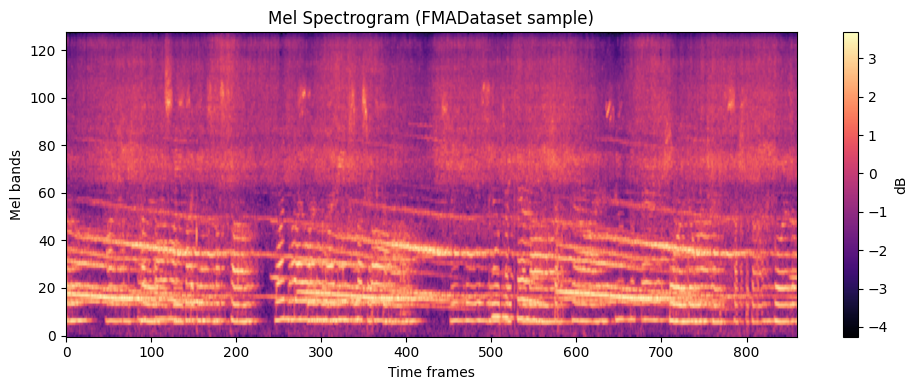

In [27]:
import matplotlib.pyplot as plt

# Get a sample from the FMADataset
sample = fma_dataset[0]

# Extract the spectrogram tensor
spec = sample['spectrogram']  # Shape: (1, 128, 860)

# Remove channel dimension for plotting and printing
spec_2d = spec.squeeze(0)  # Shape: (128, 860)

# Print a small portion (top 5 mel bands, first 10 frames)
print("Spectrogram slice (mel 0:5, frames 0:10):")
print(spec_2d[0:5, 0:10])

# Plot the full spectrogram for visual upload
plt.figure(figsize=(10, 4))
plt.imshow(spec_2d.numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title("Mel Spectrogram (FMADataset sample)")
plt.xlabel("Time frames")
plt.ylabel("Mel bands")
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()


In [25]:
# Get the first sample from FMADataset
sample = fma_dataset[0]
print("Sample type:", type(sample))
print("Sample contents:", sample)


Sample type: <class 'dict'>
Sample contents: {'spectrogram': tensor([[[-1.3644, -1.1781, -1.3095,  ..., -1.3345, -1.4305, -0.8901],
         [-1.0972, -1.1237, -0.9537,  ..., -0.8450, -1.0295, -0.7222],
         [-1.0506, -0.6537, -0.6803,  ..., -1.3136, -0.8676, -0.5556],
         ...,
         [-2.6936, -1.2533, -1.0843,  ..., -1.7959, -1.5618, -1.5887],
         [-3.6113, -2.2359, -2.0285,  ..., -2.2567, -2.2292, -2.3247],
         [-4.2555, -3.0094, -2.8328,  ..., -2.8432, -2.7690, -2.6406]]]), 'class_label': np.int64(2), 'track_id': 718}
